In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the dataset
df = pd.read_csv('tw_tweets_users_media_places.csv')


Dataset loaded with shape: (534, 34)


In [13]:
# Keep only numerical variables initially (drop object and bool variables)
# First, check the data types
print("\nData types in the dataset:")
print(df.dtypes)

# Select only numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
df_numerical = df[numerical_cols].copy()
print("\nNumerical columns:", numerical_cols.tolist())
print("Shape after keeping only numerical columns:", df_numerical.shape)

# We need to keep the text column for sentiment analysis
df_numerical['text'] = df['text']

# Add sentiment analysis
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Add sentiment columns
df_numerical['sentiment_overall'] = 0.0
df_numerical['sentiment_neg'] = 0.0
df_numerical['sentiment_neu'] = 0.0
df_numerical['sentiment_pos'] = 0.0


Data types in the dataset:
tweet_id                       int64
text                          object
context_annotations_count      int64
count_annotations            float64
count_cashtags               float64
count_hashtags               float64
count_mentions               float64
count_urls                   float64
created_at_tweet              object
lang                          object
likes                          int64
quotes                         int64
referenced_tweet_count         int64
replies                        int64
reply_settings                object
retweets                       int64
source                        object
terms                         object
username                      object
created_at_author             object
followers_count                int64
following_count                int64
tweet_count                    int64
listed_count                   int64
location                      object
protected                       bool
verified  

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ZyroY\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
import statsmodels.api as sm

df_dummy = pd.get_dummies(df_tweets, columns=['Gender', 'Weekday'], drop_first=True)

y = df_dummy.RetweetCount
X = df_dummy.drop(columns=['text', 'RetweetCount', 'sentiment_overall', 'sentiment_neg', 'sentiment_neu', 'sentiment_pos']).assign(const=1)

print(sm.OLS(y, X).fit().summary())

# Output:
# R-squared: 0.246



Numerical columns: ['tweet_id', 'context_annotations_count', 'count_annotations', 'count_cashtags', 'count_hashtags', 'count_mentions', 'count_urls', 'likes', 'quotes', 'referenced_tweet_count', 'replies', 'retweets', 'followers_count', 'following_count', 'tweet_count', 'listed_count', 'height', 'width', 'sentiment_overall', 'sentiment_neg', 'sentiment_neu', 'sentiment_pos']

Missing values in numerical columns:
tweet_id                     0
context_annotations_count    0
count_annotations            0
count_cashtags               0
count_hashtags               0
count_mentions               0
count_urls                   0
likes                        0
quotes                       0
referenced_tweet_count       0
replies                      0
retweets                     0
followers_count              0
following_count              0
tweet_count                  0
listed_count                 0
height                       0
width                        0
sentiment_overall        

In [10]:
# 3. Prepare data for regression
# Remove target variable from predictors
X_cols = [col for col in numerical_cols if col != target_col]
X = df[X_cols]
y = df[target_col]

# 4. Add constant for regression
X_with_const = sm.add_constant(X)

In [11]:
# 5. Build initial model with all numerical predictors
initial_model = sm.OLS(y, X_with_const).fit()
print("\nInitial model summary:")
print(initial_model.summary())


Initial model summary:
                            OLS Regression Results                            
Dep. Variable:               retweets   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     11.81
Date:                Mon, 31 Mar 2025   Prob (F-statistic):           1.68e-07
Time:                        22:45:03   Log-Likelihood:                -2332.1
No. Observations:                 534   AIC:                             4672.
Df Residuals:                     530   BIC:                             4689.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------


Checking for multicollinearity (VIF):
                      feature        VIF
0                       const   0.000000
1                    tweet_id   1.104726
2   context_annotations_count   1.011518
3           count_annotations   1.008623
4              count_cashtags   1.000081
5              count_hashtags   1.008640
6              count_mentions        NaN
7                  count_urls   1.005673
8                       likes   1.028374
9                      quotes   1.070636
10     referenced_tweet_count   1.009756
11                    replies   1.012885
12            followers_count   1.086712
13            following_count   1.083800
14                tweet_count   1.002852
15               listed_count  18.658036
16                     height   1.005208
17                      width   1.016739
18          sentiment_overall   1.019861
19              sentiment_neg   1.025200
20              sentiment_neu   0.895129
21              sentiment_pos   1.002567


c:\Users\ZyroY\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\ZyroY\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


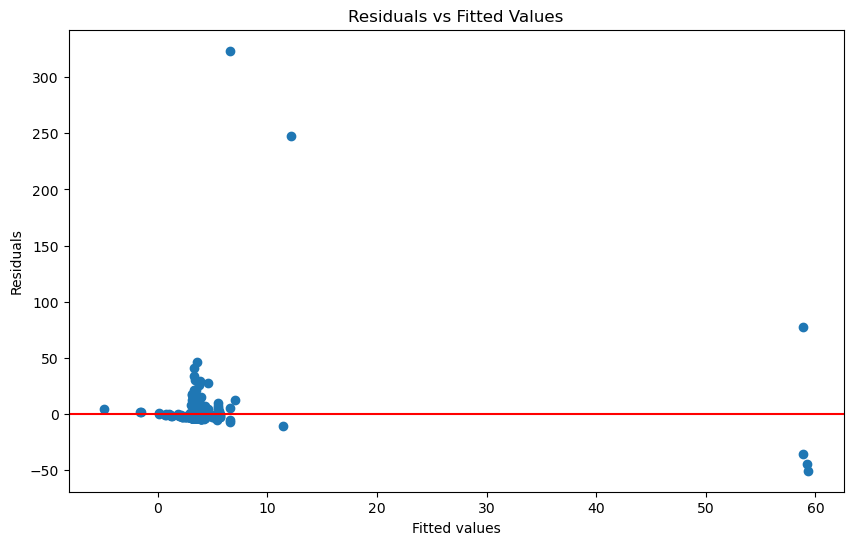

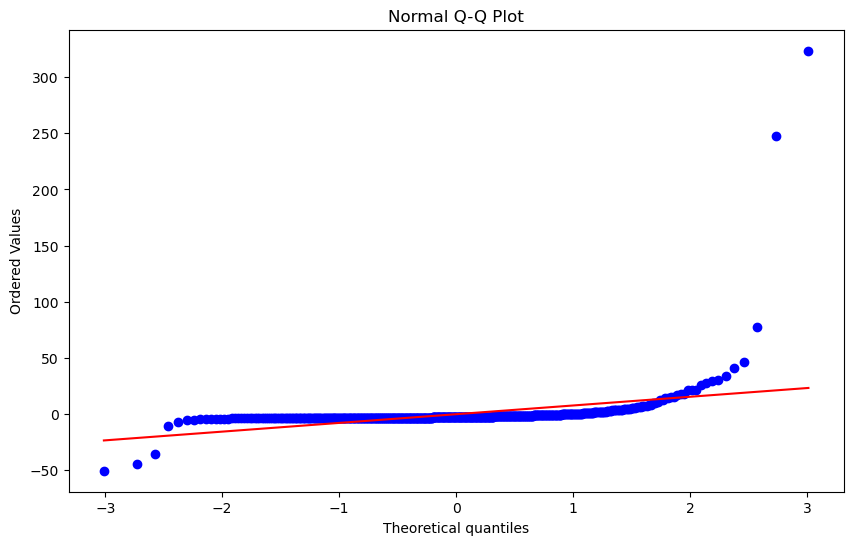

In [12]:
# Residuals vs fitted values plot
residuals = initial_model.resid
fitted = initial_model.fittedvalues

plt.figure(figsize=(10, 6))
plt.scatter(fitted, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.savefig('residuals_plot.png')

# QQ plot
from scipy import stats
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot')
plt.savefig('qq_plot.png')

# Check multicollinearity
print("\nChecking for multicollinearity (VIF):")
vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
print(vif_data)